In [15]:
import torch
import cv2
import numpy as np
import os
import sys
import time
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import lpips
import math


In [16]:
vid_path = "/home/ubuntu/seq_diffusion/autoencoder-experiments/simplest_system/720p.mp4"
vid = cv2.VideoCapture(vid_path)
# get frames
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(Image.fromarray(frame))

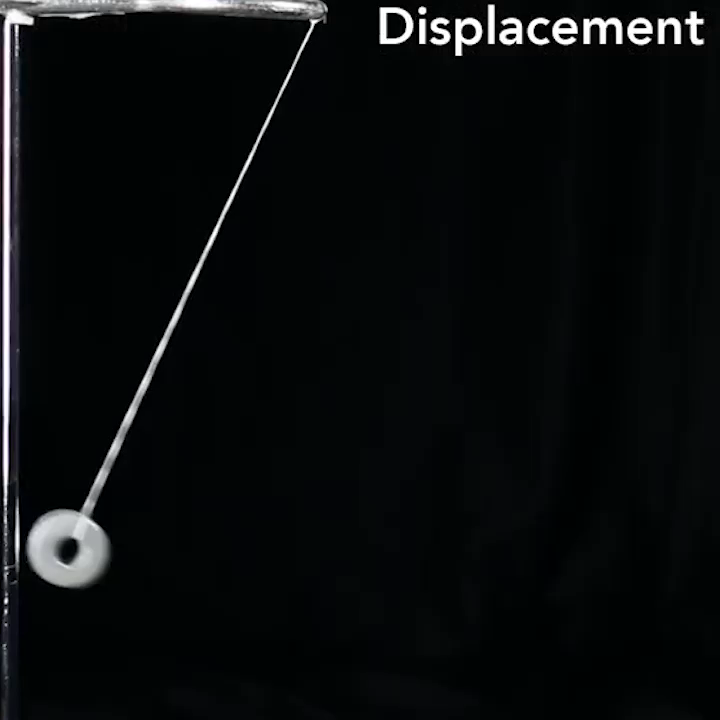

In [17]:
frames[0]

In [30]:
class ResNet(torch.nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, activation = torch.nn.ReLU):
        super(ResNet, self).__init__()
        in_dim = int(in_dim)
        mid_dim = int(mid_dim)
        out_dim = int(out_dim)
        if in_dim != out_dim:
            self.shortcut = torch.nn.Conv2d(in_dim, out_dim, kernel_size=1)
        else:
            self.shortcut = torch.nn.Identity()

        self.layers = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_dim, mid_dim, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(mid_dim, out_dim, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return self.shortcut(x) + self.layers(x)

class Autoencoder(torch.nn.Module):
    def __init__(self, depths = 9, initial_dim = 8, multiplier = 2, max_dim = 256, activation = torch.nn.SiLU, blocks=2, use_conv_transpose=True):
        super(Autoencoder, self).__init__()
        self.gradient_checkpointing = False
        self.proj_in = torch.nn.Conv2d(3, initial_dim, kernel_size=3, padding=1)
        self.proj_out = torch.nn.Conv2d(initial_dim, 3, kernel_size=3, padding=1)

        layers = []
        for i in range(depths):
            for j in range(blocks):
                if j == 0:
                    in_dim = min(initial_dim * (multiplier**i), max_dim)
                else:
                    in_dim = min(initial_dim * (multiplier**(i+1)), max_dim)
                out_dim = min(initial_dim * (multiplier**(i+1)), max_dim)
                layers.append(ResNet(in_dim, out_dim, out_dim, activation))
            layers.append(torch.nn.MaxPool2d(2))
        
        self.encoder = torch.nn.ModuleList(layers)

        final_dim = int(min(initial_dim * (multiplier**depths), max_dim))
        self.bottleneck = torch.nn.Conv2d(final_dim, 1, kernel_size=1)
        self.expand = torch.nn.Conv2d(1, final_dim, kernel_size=1)

        layers = []
        for i in range(depths):
            for j in range(blocks):
                if j == 0:
                    in_dim = min(initial_dim * (multiplier**(depths-i)), max_dim)
                else:
                    in_dim = min(initial_dim * (multiplier**(depths-i-1)), max_dim)
                out_dim = min(initial_dim * (multiplier**(depths-i-1)), max_dim)
                layers.append(ResNet(in_dim, out_dim, out_dim, activation))
            if use_conv_transpose:
                layers.append(torch.nn.Upsample(scale_factor=2))
        
        self.decoder = torch.nn.ModuleList(layers)
    
    def enable_gradient_checkpointing(self):
        self.gradient_checkpointing = True

    def encode(self, x):
        x = self.proj_in(x)
        for layer in self.encoder:
            if self.gradient_checkpointing:
                x = torch.utils.checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.bottleneck(x)
        return x

    def decode(self, x):
        x = self.expand(x)
        for layer in self.decoder:
            if self.gradient_checkpointing:
                x = torch.utils.checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.proj_out(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x


In [32]:
# train
lpips_loss_factor = 1.0
l1_loss_factor = 1.0
l2_loss_factor = 1.0
max_grad_norm = 1.0
steps = 2000
gradient_checkpointing = True
batch_size = 8
lr = 0.00015
size = 256
max_dim = 512
blocks = 2
multiplier = 1.8
initial_dim = 16

# center crop all of them
resize = transforms.Compose([
    transforms.Resize((size)),
    transforms.CenterCrop((size))
])

frames_data = [resize(frame) for frame in frames]

autoencoder = Autoencoder(depths = int(math.log2(size)), initial_dim=initial_dim, max_dim = max_dim, blocks=blocks, multiplier=multiplier).cuda()
if gradient_checkpointing:
    autoencoder.enable_gradient_checkpointing()

l2_criterion = torch.nn.MSELoss()
l1_criterion = torch.nn.L1Loss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0, steps)

if lpips_loss_factor > 0:
    loss_fn_vgg = lpips.LPIPS(net='vgg').cuda()

data = torch.stack([transforms.ToTensor()(frame) for frame in frames_data]).cuda()
data = data.view(-1, 3, size, size) * 2 - 1

pbar = tqdm(range(steps))
for i in pbar:
    optimizer.zero_grad()
    mini_batch_indices = torch.randperm(data.size(0))[:batch_size]
    mini_batch = data[mini_batch_indices]
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        output = autoencoder(mini_batch)
        losses = {}
        loss = torch.tensor(0.0).cuda()

        if l2_loss_factor > 0:
            l2_loss = l2_criterion(output, mini_batch)
            loss += l2_loss_factor * l2_loss.mean()
            losses["l2"] = l2_loss.item()
        if l1_loss_factor > 0:
            l1_loss = l1_criterion(output, mini_batch)
            loss += l1_loss_factor * l1_loss.mean()
            losses["l1"] = l1_loss.item()
        if lpips_loss_factor > 0:
            lpips_loss = loss_fn_vgg(output, mini_batch)
            loss += lpips_loss_factor * lpips_loss.mean()
            losses["lpips"] = lpips_loss.mean().item()

    losses_string = " ".join([f"{k}: {v}" for k, v in losses.items()])

    loss.backward()
    grad_norm = 0
    if max_grad_norm > 0:
        grad_norm = torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()
    pbar.set_description(f"{losses_string} lr: {scheduler.get_last_lr()[0]} grad_norm: {grad_norm}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/2000 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
l2: 0.034440748393535614 l1: 0.0489494763314724 lpips: 0.16015625 lr: 7.499999999999921e-07 grad_norm: 0.5684822201728821: 100%|█████████▉| 1990/2000 [04:13<00:01,  7.79it/s]     

In [6]:
with torch.no_grad():
    output = autoencoder.encode(data)
    max_val = output.max()
    min_val = output.min()
    print(max_val, min_val)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


tensor(0.1655, device='cuda:0') tensor(0.1609, device='cuda:0')


In [10]:
zs = torch.linspace(min_val, max_val, 100).cuda()

In [11]:
with torch.no_grad():
    output = autoencoder.decode(zs[:, None, None, None])
    output = output.view(zs.shape[0], 3, size, size) / 2 + 0.5
    all_images = []
    for i in range(output.size(0)):
        all_images.append(transforms.ToPILImage()(output[i].cpu()))

/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [5]:
# all_images[50]

In [1]:
from PIL import Image

In [2]:
img = Image.open("./pendulum.png")

In [3]:
all_frames = []
for i in range(10):
    for j in range(10):
        all_frames.append(img.crop((i*256, j*256, (i+1)*256, (j+1)*256)))

In [4]:
import os
import numpy as np
from moviepy.editor import ImageSequenceClip

def create_video_moviepy(frames, output_path, fps=25):
    frames = [np.array(frame) for frame in frames]
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(output_path)
    clip.close()

create_video_moviepy(all_frames, "output.mp4", fps=25)

ModuleNotFoundError: No module named '_cffi_backend'

thread '<unnamed>' panicked at /github/home/.cargo/registry/src/index.crates.io-6f17d22bba15001f/pyo3-0.20.3/src/err/mod.rs:788:5:
Python API call failed
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
